In [43]:
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
from pytorch_models import GRU_classifier,LSTM_classifier,GRU_regressor,LSTM_regressor
import torch
from csv_to_data import *
import sys
import json
import urllib.request
from time import sleep
import time 

# pytorch implemention of LSTM and Gated recurrent unit (GRU)

### regression seems to give better results than classification

In [44]:
def prec_thr(model,test,thresh):
    '''
    Computes the probability the price will increase when the 
    model predicts an increase grether than the threshold. 
    
    '''
    model.hidden = torch.zeros(h_size)
    try:

        model.cell = torch.zeros(h_size)
    except:
        pass 
    prec = 0
    count = 0
    pred = []
    for x,t in test[0]:
        y_hat = model.forward(x)
        #print(y_hat)
        pred.append(y_hat.data)
        if y_hat>thresh:
            count += 1
            if t>0:
                prec += 1
    return prec/count 


In [45]:
#Read in the data 
path = 'appleData/'
df1 = pd.read_csv(path+'aapl.txt')
df2 = pd.read_csv(path+'aapl2.txt')
df3 = pd.read_csv(path+'aapl3.txt')
df4 = pd.read_csv(path+'aapl4.txt')
df5 = pd.read_csv(path+'aapl5.txt')
df6 = pd.read_csv(path+'aapl6.txt')
df7 = pd.read_csv(path+'aapl7.txt')
#df1,df2,and df3 are from different days so we want to keep
#them separate when constructing the data set 
#For now Time will not explicitly be a variable so will drop from data frame
df1=df1.drop('time',axis=1)
df2=df2.drop('time',axis=1)
df3=df3.drop('time',axis=1)
df4=df4.drop('time',axis=1)
df5=df5.drop('time',axis=1)
df6=df6.drop('time',axis=1)
df7=df7.drop('time',axis=1)
#Even after waiting a minute there isn't always a new data point so want to drop duplicates so we dont 
#end up with duplicate data in the train and test sets
df1=df1.drop_duplicates()
df2=df2.drop_duplicates()
df3= df3.drop_duplicates()
df4=df4.drop_duplicates()
df5=df5.drop_duplicates()
df6=df6.drop_duplicates()
df7=df7.drop_duplicates()

In [46]:
def data_frames_to_train_pytorchR(df_lst,look_back):
    
    #First will construct new features
    D = []
    At = []
    Ac = []
    for i,df in enumerate(df_lst):
        d = []
        at = []
        ac = []
        for j in range(look_back,len(df)-1):

            avg = np.mean(df.iloc[:j,4])
            features = [df.iloc[j,4]-df.iloc[j-num,4] for num in range(1,look_back+1)]
            features.append(df.iloc[j,4]-avg)
            target = df.iloc[j+1,4]-df.iloc[j,4] 

            d.append((torch.Tensor(features),target))
            at.append(df.iloc[j+1,4])
            ac.append(df.iloc[j,4])
        At.append(at)
        Ac.append(ac)
        D.append(d)
    return D,At,Ac 

In [47]:
look_back = 10

In [48]:
DataR,Atr,Acr = data_frames_to_train_pytorchR([df6,df1,df2,df4,df5,df7],look_back)
testR,Att,Act = data_frames_to_train_pytorchR([df3],look_back)

In [49]:
h_size = 64
model1 = GRU_regressor(look_back+1,h_size)
model2 = LSTM_regressor(look_back+1,h_size)


In [57]:
model2.train(DataR,epochs=100)

epoch 0 loss 2.740072727203369
epoch 1 loss 2.7074801921844482
epoch 2 loss 2.766449451446533
epoch 3 loss 2.7076303958892822
epoch 4 loss 2.606067180633545
epoch 5 loss 2.693654775619507
epoch 6 loss 2.5893144607543945
epoch 7 loss 2.6310336589813232
epoch 8 loss 2.6783511638641357
epoch 9 loss 2.6326940059661865
epoch 10 loss 2.5582058429718018
epoch 11 loss 2.620140552520752
epoch 12 loss 2.619180679321289
epoch 13 loss 2.6112823486328125
epoch 14 loss 2.5644209384918213
epoch 15 loss 2.596876382827759
epoch 16 loss 2.5247652530670166
epoch 17 loss 2.5345871448516846
epoch 18 loss 2.5530691146850586
epoch 19 loss 2.6505911350250244
epoch 20 loss 2.759042978286743
epoch 21 loss 2.6992170810699463
epoch 22 loss 2.508497714996338
epoch 23 loss 2.509019613265991
epoch 24 loss 2.533430576324463
epoch 25 loss 2.578828811645508
epoch 26 loss 2.5112171173095703
epoch 27 loss 2.560472011566162
epoch 28 loss 2.479508876800537
epoch 29 loss 2.491227149963379
epoch 30 loss 2.5616204738616943
ep

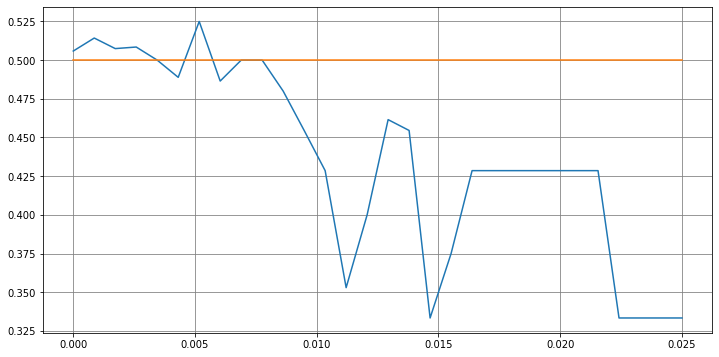

In [61]:
thresh = np.linspace(0,.025,30)
        
pr = [prec_thr(model2,testR,t) for t in thresh]

plt.figure(figsize=(12,6))

plt.plot(thresh,pr)
plt.plot([np.min(thresh),np.max(thresh)],[.5,.5])

plt.grid(color='grey')

In [62]:
pred = []
for x,t in testR[0]:
    pred.append(model2.forward(x))

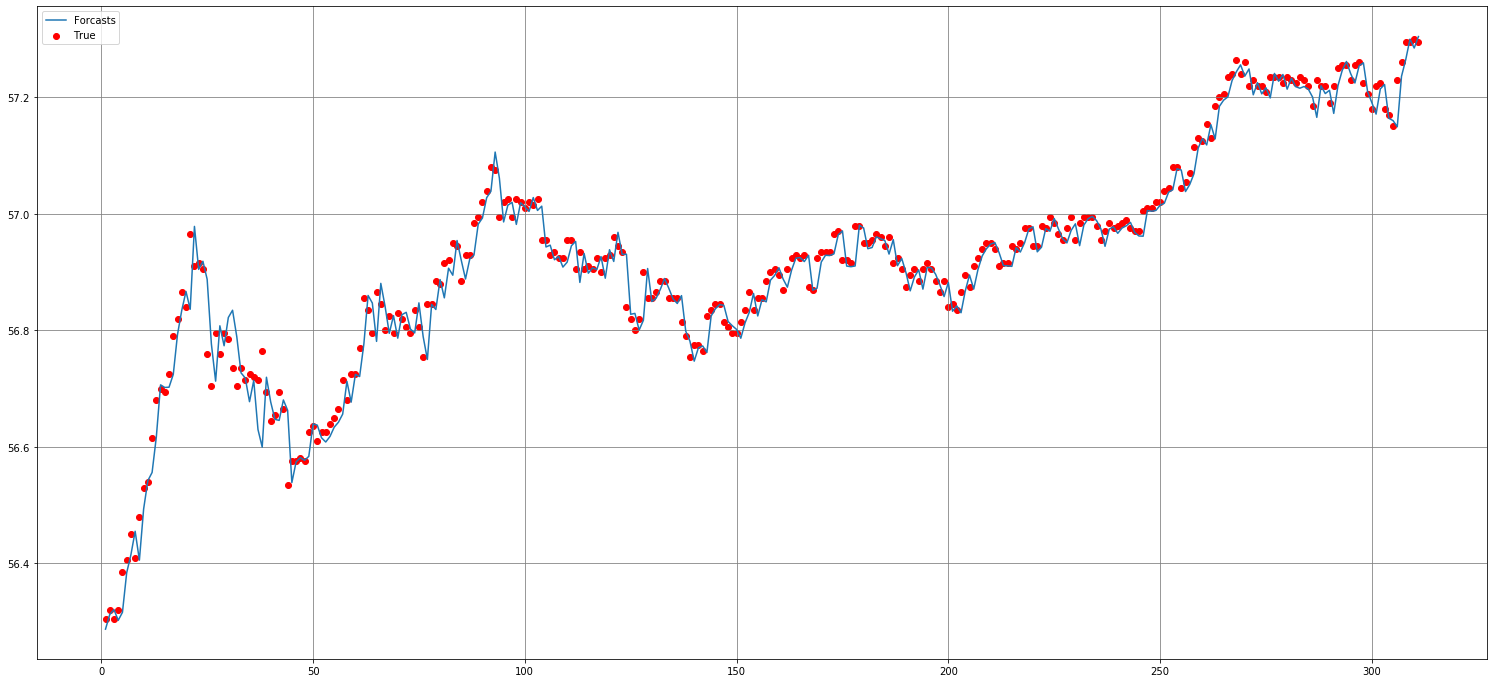

In [63]:
plt.figure(figsize=(26,12))
xx = [n for n in range(1,len(pred)+1)]
true = Att[0]

forcasts = [pred[i] + Act[0][i] for i in range(len(pred))]
plt.plot(xx,forcasts,label='Forcasts')
plt.scatter(xx,true,label='True',color='red')
plt.legend()

plt.grid(color='grey')


In [ ]:
pred

In [60]:
class forcaster:
    
    def __init__(self,model,stock,look_back):
        self.model = model 
        self.stock = stock
        self.look_back = look_back
        self.forcasts = []
        self.actual = []
        self.money = 1e4
        self.data = []
        self.shares = 0
        self.last_data = None
        
    def forcast(self):
        token ='pk_47eece3cb483468bb6728475f75b79ce'
        while True:
            while True:
                try:
                    html = urllib.request.urlopen("https://cloud.iexapis.com/stable/tops?token="+token+"&symbols="+self.stock)
                    lst = json.loads(html.read().decode('utf-8'))
                    if lst[0] != self.last_data:
                        self.last_data = lst[0]
                        break
                except:
                    pass 
            d = lst[0]
            self.data.append(d['lastSalePrice'])
            
            if len(d)>look_back:
                if len(d)>look_back+1:
                    self.actual.append(self.data[-1])
                avg = np.mean(self.data)
                features = [self.data[-1]-self.data[-1-num] for num in range(1,look_back+1)]
                features.append(self.data[-1]-avg)
                x = torch.Tensor(features)
                prediction = self.model.forward(x)
                self.forcasts.append(self.data[-1]+prediction)
                xx = [n for n in range(len(forcasts))]
                plt.figure(figsize=(14,7))
                plt.plot(xx,self.forcasts,label='Forcasts')
                plt.scatter(xx[:len(self.actual)],self.true,label='True')
                plt.legend()
                plt.grid(color='grey')
            sleep(60)
            
        

In [61]:
forcast = forcaster(model1,'mu',10)

In [ ]:
forcast.forcast()